In [70]:
from sklearn.metrics import (confusion_matrix, 
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

from tqdm import trange, tqdm

import warnings
warnings.filterwarnings('ignore')

# Анализ датасета

In [71]:
df = pd.read_csv('diabetes.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [72]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


### Анализ пропущенных значений

In [73]:
df['smoking_history'] = df['smoking_history'].replace(['No Info'], np.NaN)

In [74]:
print(f'Количество объектов с пропущенными значениями: {df.isnull().any(axis = 1).sum()}') 

Количество объектов с пропущенными значениями: 35816


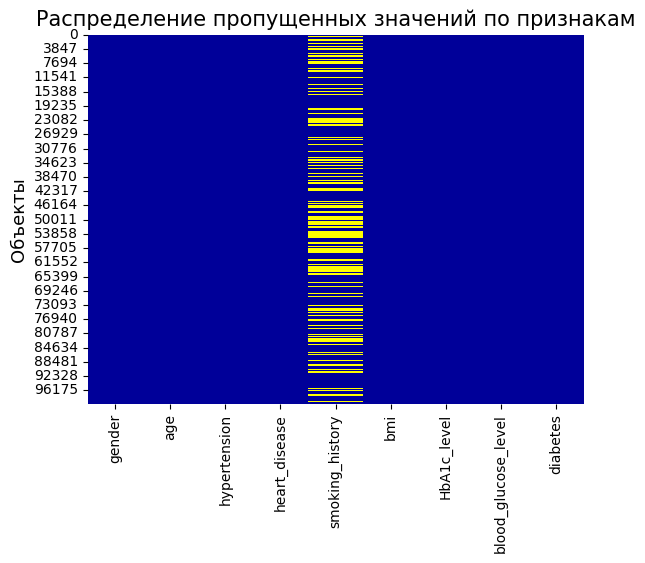

In [75]:
s = sns.heatmap(df.isnull(), cmap = sns.color_palette(['#000099', '#ffff00']), cbar = False)
s.set_ylabel('Объекты', fontsize = 13)
s.set_title('Распределение пропущенных значений по признакам', fontsize = 15)

plt.show()

In [76]:
mis = {}

for feature in df.columns:
    mis[feature] = np.mean(df[feature].isnull()) * 100

for feature, val in sorted(mis.items(), key = lambda item: item[1], reverse = True):
    print(f'{feature} - {np.mean(df[feature].isnull()) * 100:.2f}%')

smoking_history - 35.82%
gender - 0.00%
age - 0.00%
hypertension - 0.00%
heart_disease - 0.00%
bmi - 0.00%
HbA1c_level - 0.00%
blood_glucose_level - 0.00%
diabetes - 0.00%


In [77]:
df = df.dropna()

In [78]:
print(f'Количество объектов с пропущенными значениями: {df.isnull().any(axis = 1).sum()}') 

Количество объектов с пропущенными значениями: 0


### Перевод категориальных признаков в числовые

In [79]:
df = pd.concat([df.drop(['gender'], axis = 1), pd.get_dummies(df['gender'], dtype = int)], axis = 1)
df = pd.concat([df.drop(['smoking_history'], axis = 1), pd.get_dummies(df['smoking_history'], dtype = int)], axis = 1)

df

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,Male,Other,current,ever,former,never,not current
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,1,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,1,0,0,0,0
5,20.0,0,0,27.32,6.6,85,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,26.0,0,0,34.34,6.5,160,0,1,0,0,0,0,0,1,0
99993,40.0,0,0,40.69,3.5,155,0,1,0,0,0,0,0,1,0
99997,66.0,0,0,27.83,5.7,155,0,0,1,0,0,0,1,0,0
99998,24.0,0,0,35.42,4.0,100,0,1,0,0,0,0,0,1,0


### Анализ выбросов

In [80]:
def show_boxplots(df, title = None):

    rows_cnt = int(np.ceil(len(df.columns) / 2))

    fig = plt.figure(layout = 'constrained', figsize = (10, 6))
    gs = GridSpec(rows_cnt, 2, figure = fig)

    for i, feature in enumerate(df.columns):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        df.boxplot(column = feature, ax = ax)

    plt.suptitle(title, fontsize = 15)
    plt.show()

In [81]:
binary_features = [col for col in df if np.isin(df[col].unique(), [0, 1]).all()]
binary_features

['hypertension',
 'heart_disease',
 'diabetes',
 'Female',
 'Male',
 'Other',
 'current',
 'ever',
 'former',
 'never',
 'not current']

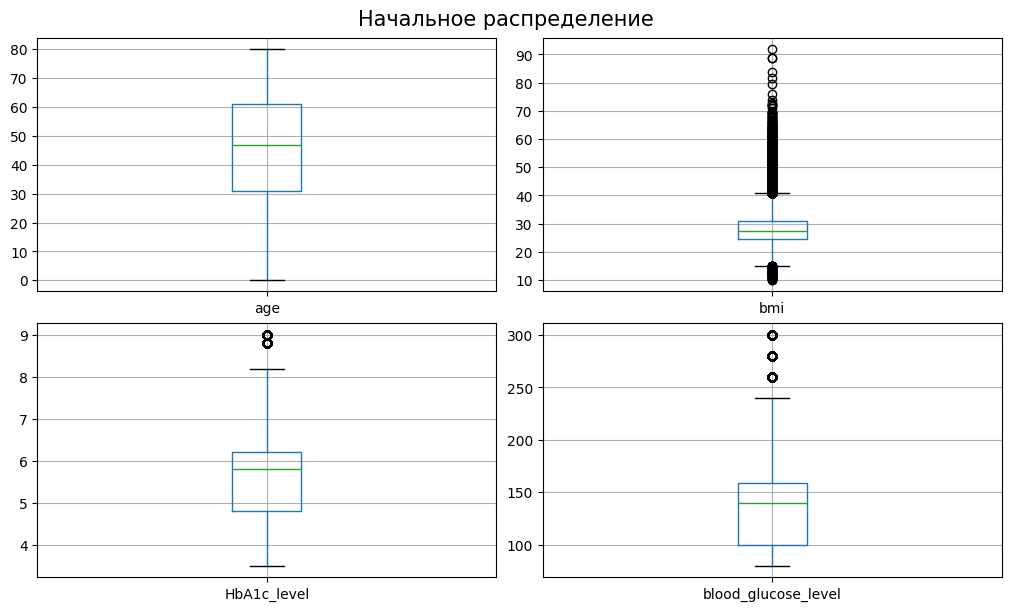

In [82]:
show_boxplots(df.drop(binary_features, axis = 1), title = 'Начальное распределение')

In [83]:
for feature in df.drop(binary_features, axis = 1).columns:

    Q1 = df[feature].quantile(q = .25)
    Q3 = df[feature].quantile(q = .75)
    IQR = Q3 - Q1

    df = df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 * IQR)] 

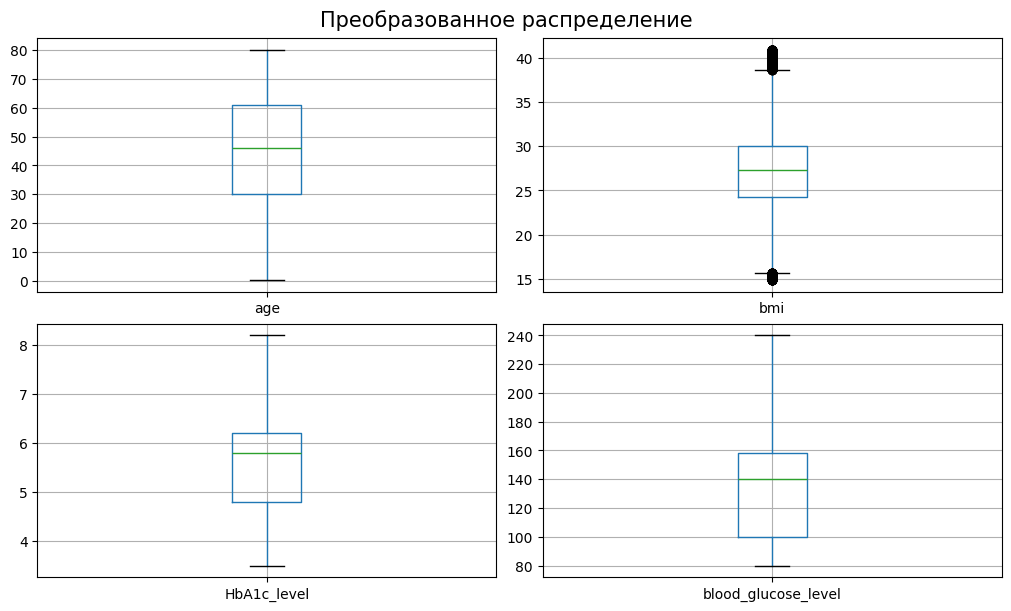

In [84]:
show_boxplots(df.drop(binary_features, axis = 1), title = 'Преобразованное распределение')

### Распределение классов

In [85]:
def classes_distr(df, title = None):
    plt.figure(figsize = (5, 5))
    plt.rc('xtick', labelsize = 10)

    plot = sns.countplot(x = 'diabetes', data = df, palette = ["#0101DF", "#DF0101"], edgecolor = 'black')

    for p in plot.patches:
        plot.annotate(int(p.get_height()),
                    (p.get_x() + p.get_width() / 2., p.get_height()),  
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 7), 
                    textcoords = 'offset points')

    plt.title(title, fontsize = 15, pad = 20)

    plt.tight_layout()
    plt.show()

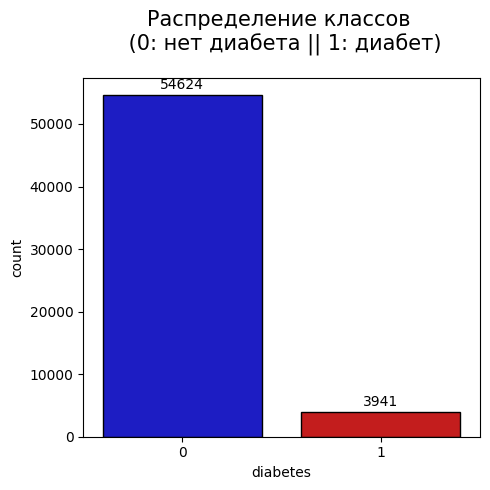

In [86]:
classes_distr(df, title = 'Распределение классов \n (0: нет диабета || 1: диабет)')

### Корреляция

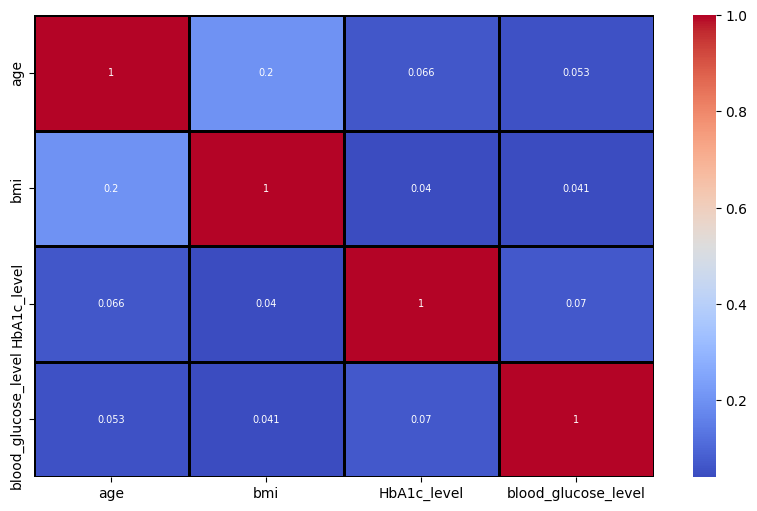

In [87]:
plt.figure(figsize = (10, 6))

sns.heatmap(df.drop(binary_features, axis = 1).corr(), 
            cmap = 'coolwarm', 
            linewidths = 2, 
            linecolor = 'black', 
            annot = True,
            annot_kws = {"fontsize" : 7})

plt.show()

# Задание 1

### Разделение на train и test

In [88]:
not_diabetes = df[df['diabetes'] == 0]
diabetes = df[df['diabetes'] == 1]

In [89]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(not_diabetes.drop(['diabetes'], axis = 1), not_diabetes['diabetes'], test_size = .2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(diabetes.drop(['diabetes'], axis = 1), diabetes['diabetes'], test_size = .2)

In [90]:
X_train = pd.concat([X_train1, X_train2]).sample(frac = 1)
X_test  = pd.concat([X_test1, X_test2]).sample(frac = 1)

y_train = pd.concat([y_train1, y_train2]).sample(frac = 1)
y_test = pd.concat([y_test1, y_test2]).sample(frac = 1)

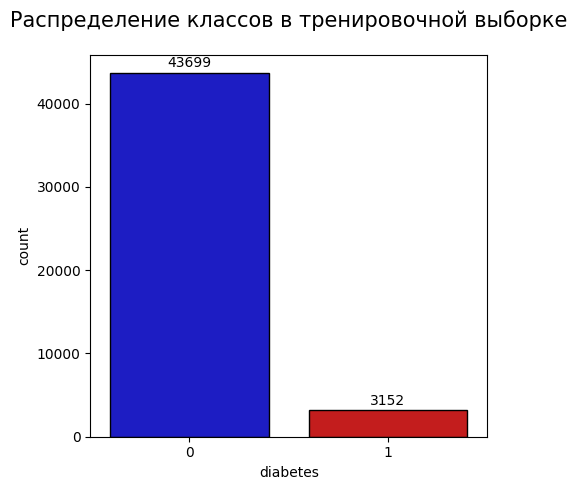

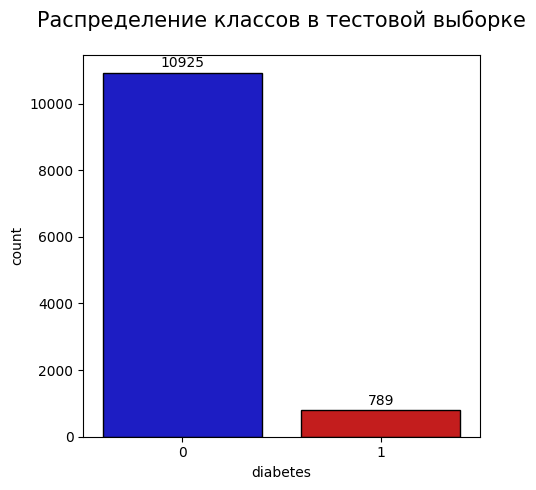

In [91]:
classes_distr(pd.DataFrame(y_train), title = 'Распределение классов в тренировочной выборке')
classes_distr(pd.DataFrame(y_test), title = 'Распределение классов в тестовой выборке')

### Классификация

In [92]:
weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
np.unique(weights)

array([0.5360649 , 7.43194797])

In [93]:
estimator = GradientBoostingClassifier(max_depth = 5).fit(X_train, y_train, sample_weight = weights)
y_pred = estimator.predict(X_test)

<Figure size 600x600 with 0 Axes>

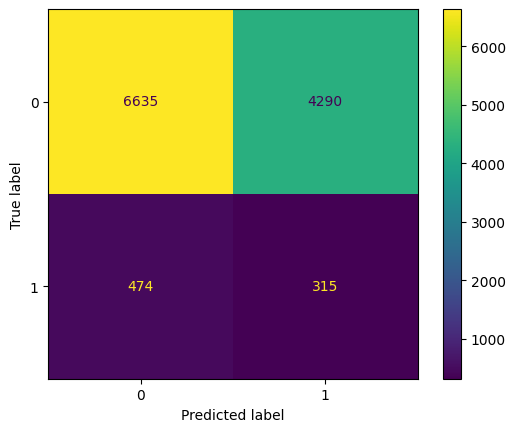

In [94]:
plt.figure(figsize = (6, 6))

ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)

plt.show()

# Задание 2

In [95]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
specificity = tn / (tn + fp) * 100

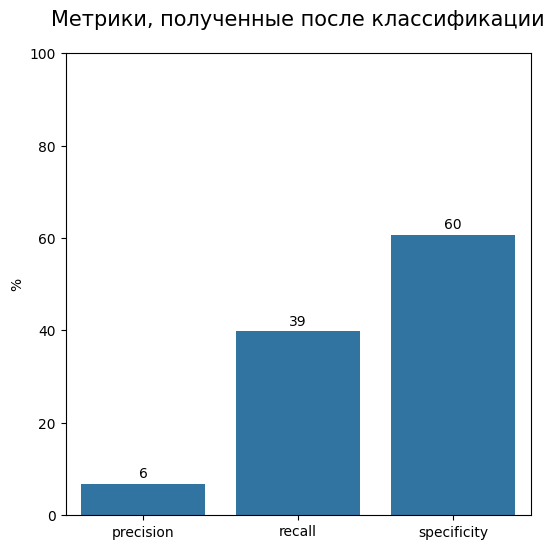

In [96]:
data = dict(x = ['precision', 'recall', 'specificity'], y = [precision, recall, specificity])
data = pd.DataFrame(data)

plt.figure(figsize = (6, 6))
plt.rc('xtick', labelsize = 10)

plot = sns.barplot(x = 'x', y = 'y', data = data)

for p in plot.patches:
    plot.annotate(int(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center', 
                va = 'center', 
                xytext = (0, 7), 
                textcoords = 'offset points')

plt.ylim([0, 100])

plt.xlabel('')
plt.ylabel('%')

plt.title('Метрики, полученные после классификации', fontsize = 15, pad = 20)
plt.show()

# Задание 3

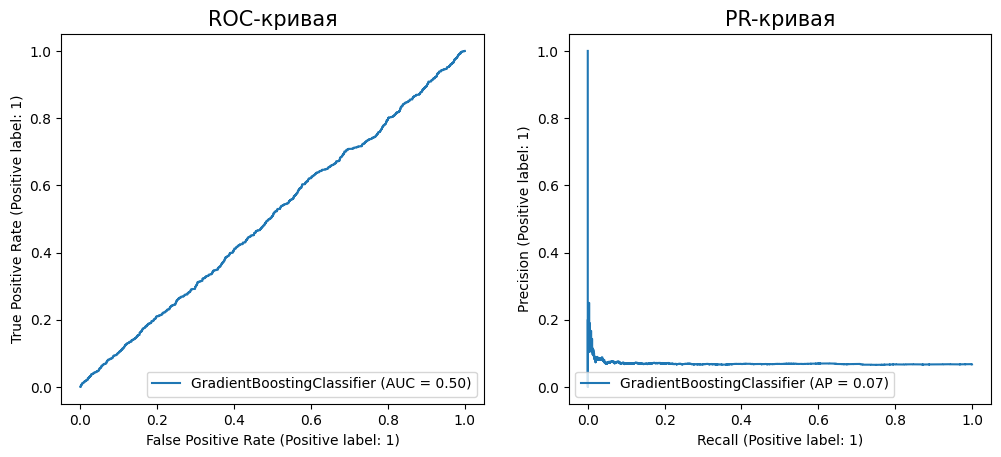

In [97]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax = ax[0])
PrecisionRecallDisplay.from_estimator(estimator, X_test, y_test, ax = ax[1])

ax[0].set_title('ROC-кривая', fontsize = 15)
ax[1].set_title('PR-кривая', fontsize = 15)

plt.show()

# Задание 4

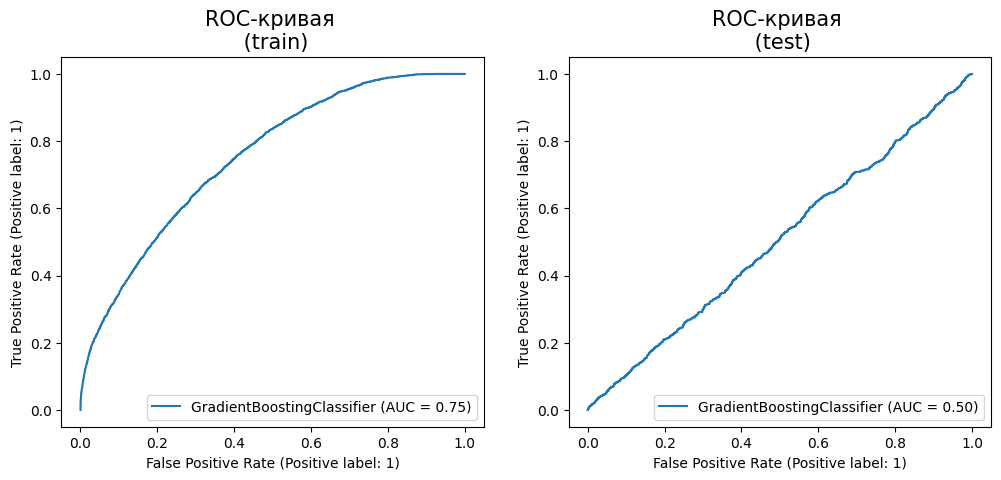

In [98]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

RocCurveDisplay.from_estimator(estimator, X_train, y_train, ax = ax[0])
RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax = ax[1])

ax[0].set_title('ROC-кривая \n (train)', fontsize = 15)
ax[1].set_title('ROC-кривая \n (test)', fontsize = 15)

plt.show()

# Задание 5

In [99]:
ada_boost_aucs = []
grad_boost_aucs = []

for n_estimators in trange(50, 100):

    ada_boost = AdaBoostClassifier(n_estimators = n_estimators).fit(X_train, y_train, sample_weight = weights)
    grad_boost = GradientBoostingClassifier(n_estimators = n_estimators).fit(X_train, y_train, sample_weight = weights)

    ada_boost_aucs.append(roc_auc_score(y_test, ada_boost.predict(X_test)) * 100)
    grad_boost_aucs.append(roc_auc_score(y_test, grad_boost.predict(X_test)) * 100)

100%|██████████| 50/50 [02:51<00:00,  3.43s/it]


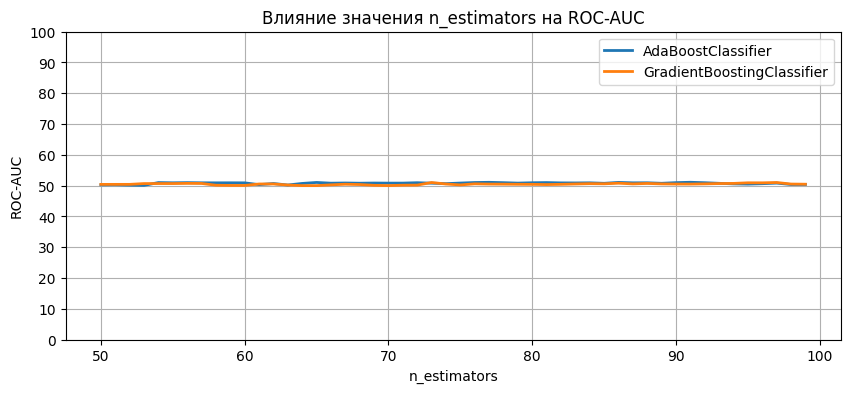

In [100]:
plt.figure(figsize = (10, 4))

plt.plot(range(50, 100), ada_boost_aucs, linewidth = 2, label = 'AdaBoostClassifier')
plt.plot(range(50, 100), grad_boost_aucs, linewidth = 2, label = 'GradientBoostingClassifier')

plt.xlabel('n_estimators') 
plt.ylabel('ROC-AUC')

plt.yticks(range(0, 101, 10))

plt.title('Влияние значения n_estimators на ROC-AUC')

plt.legend()
plt.grid()

plt.show()

In [101]:
ada_boost_aucs = []
grad_boost_aucs = []

for learning_rate in tqdm(np.arange(0.01, 1, 0.05)):

    ada_boost = AdaBoostClassifier(learning_rate  = learning_rate).fit(X_train, y_train, sample_weight = weights)
    grad_boost = GradientBoostingClassifier(learning_rate  = learning_rate).fit(X_train, y_train, sample_weight = weights)

    ada_boost_aucs.append(roc_auc_score(y_test, ada_boost.predict(X_test)) * 100)
    grad_boost_aucs.append(roc_auc_score(y_test, grad_boost.predict(X_test)) * 100)

100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


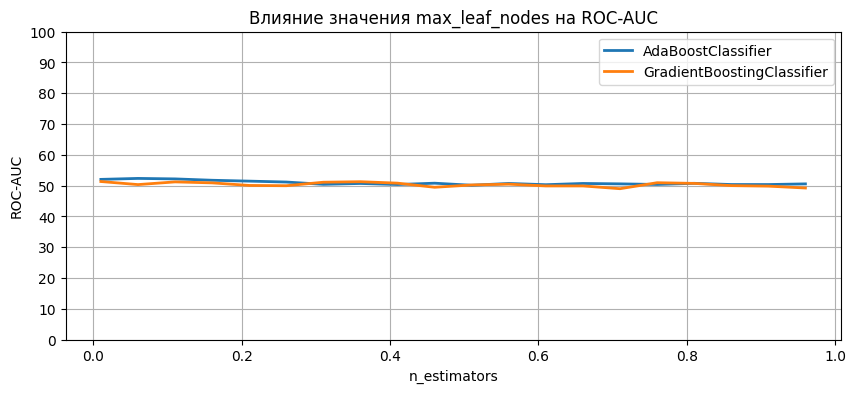

In [102]:
plt.figure(figsize = (10, 4))

plt.plot(np.arange(0.01, 1, 0.05), ada_boost_aucs, linewidth = 2, label = 'AdaBoostClassifier')
plt.plot(np.arange(0.01, 1, 0.05), grad_boost_aucs, linewidth = 2, label = 'GradientBoostingClassifier')

plt.xlabel('n_estimators') 
plt.ylabel('ROC-AUC')

plt.yticks(range(0, 101, 10))

plt.title('Влияние значения max_leaf_nodes на ROC-AUC')

plt.legend()
plt.grid()

plt.show()